# Himawari Imagery

[Himawari](https://www.jma.go.jp/jma/jma-eng/satellite/introduction.html) data access was added in pycontrails 0.57.0. This notebook demonstrates basic usage.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from pycontrails.datalib.goes import GOES
from pycontrails.datalib.goes import extract_visualization as extract_goes_visualization
from pycontrails.datalib.himawari import Himawari
from pycontrails.datalib.himawari import extract_visualization as extract_himawari_visualization

## Himawari Interface

The `Himawari` interface was designed to mirror the `GOES` interface. See the [GOES notebook](https://py.contrails.org/notebooks/GOES.html) for some examples.

The table below summarizes the differences in parameters.

| Parameter         | `GOES`                                   | `Himawari`                                         |
|---------------|----------------------------------------|--------------------------------------------------|
| `region`        | `F` (Full Disk), `C` (CONUS), `M1` (Mesoscale 1), `M2` (Mesoscale 2) | `F` (Full Disk), `J` (Japan), `T` (Target)       |
| `bands`  | `C01`–`C16` (e.g., `C11`, `C14`)       | `B01`–`B16` (e.g., `B11`, `B14`)                 |
| `bucket`        | `gcp-public-data-goes-16` (GOES-16), `None` (bucket determined by date)   | `noaa-himawari8` (Himawari-8), `None` (bucket determined by date) |

There are slight differences in the available channels/bands between GOES and Himawari. Himawari includes a true green band ("B02" in Himawari) and does not include a cirrus band ("C04" in GOES). It's also worth noting that bands shared between the two instruments differ slightly (e.g., the longwave window bands used for the ash color scheme are centered at 8.6, 11.2, and 12.4 um on Himawari and 8.4, 11.2, and 12.3 um on GOES).

- [Himawari band definitions](https://www.data.jma.go.jp/mscweb/en/himawari89/space_segment/spsg_ahi.html#band)
- [GOES band definitions](https://www.goes-r.gov/mission/ABI-bands-quick-info.html)

In [2]:
hima = Himawari(region="F", bands=("B11", "B14", "B15"))
da_h = hima.get("2023-10-01T12:00:00")
da_h

<xarray.DataArray 'CMI' (band_id: 3, y: 5500, x: 5500)> Size: 363MB
dask.array<getitem, shape=(3, 5500, 5500), dtype=float32, chunksize=(1, 5500, 5500), chunktype=numpy.ndarray>
Coordinates:
  * band_id  (band_id) int32 12B 11 14 15
  * x        (x) float32 22kB -0.1537 -0.1537 -0.1536 ... 0.1535 0.1536 0.1536
  * y        (y) float32 22kB 0.1537 0.1537 0.1536 ... -0.1535 -0.1536 -0.1536
    t        datetime64[ns] 8B ...
Attributes:
    crs:            +proj=geos +h=35785863.0 +a=6378137.0 +b=6356752.3 +lon_0...
    long_name:      Advanced Himawari Imager (AHI) brightness temperature
    standard_name:  toa_brightness_temperature
    units:          K

## Visualize Himawari

Use the `extract_visualization` function to create the necessary data for a `matplotlib` + `cartopy` visualization. Just as with GOES data, set the `color_scheme` parameter to one of `"true"` or `"ash"` to create RGB composites.

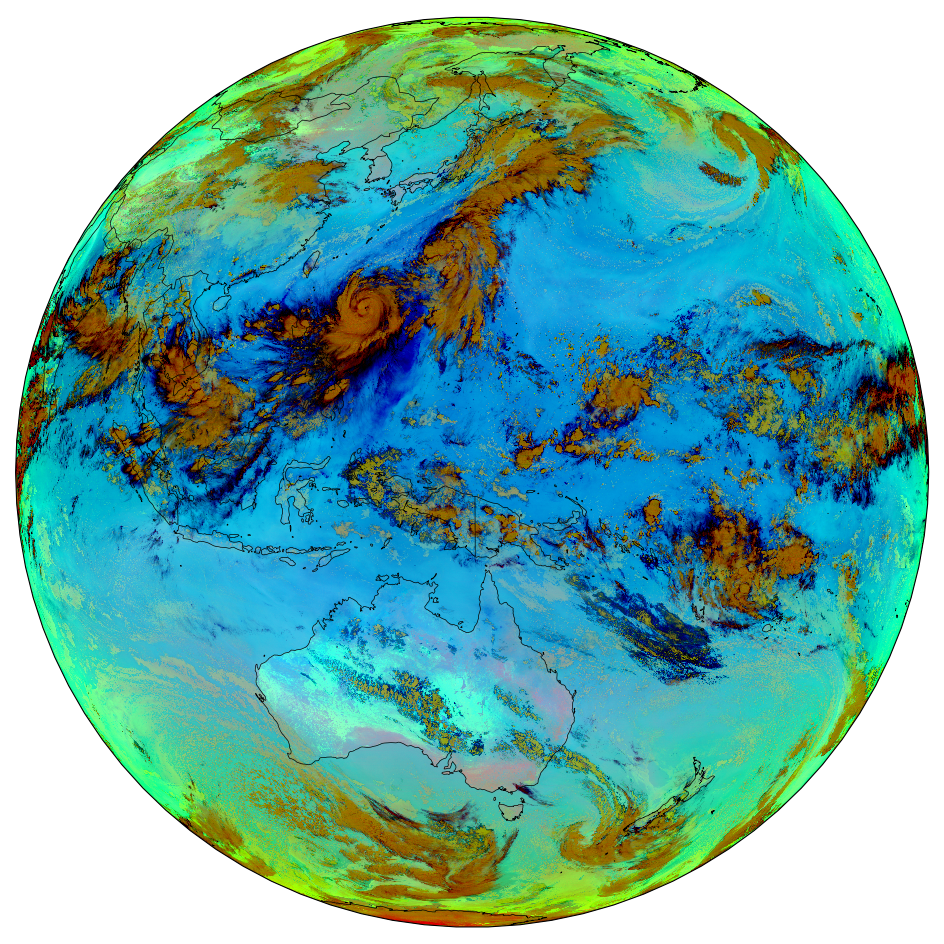

In [3]:
rgb, src_crs, src_extent = extract_himawari_visualization(da_h, color_scheme="ash")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection=src_crs)
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, interpolation="none");

## GEO Mosaic

It's possible to stitch together GOES and Himawari imagery to create a near-global mosaic. While the corresponding bands are similar, they are not identical. This explains some of the color differences across the seam in the mosaic below.

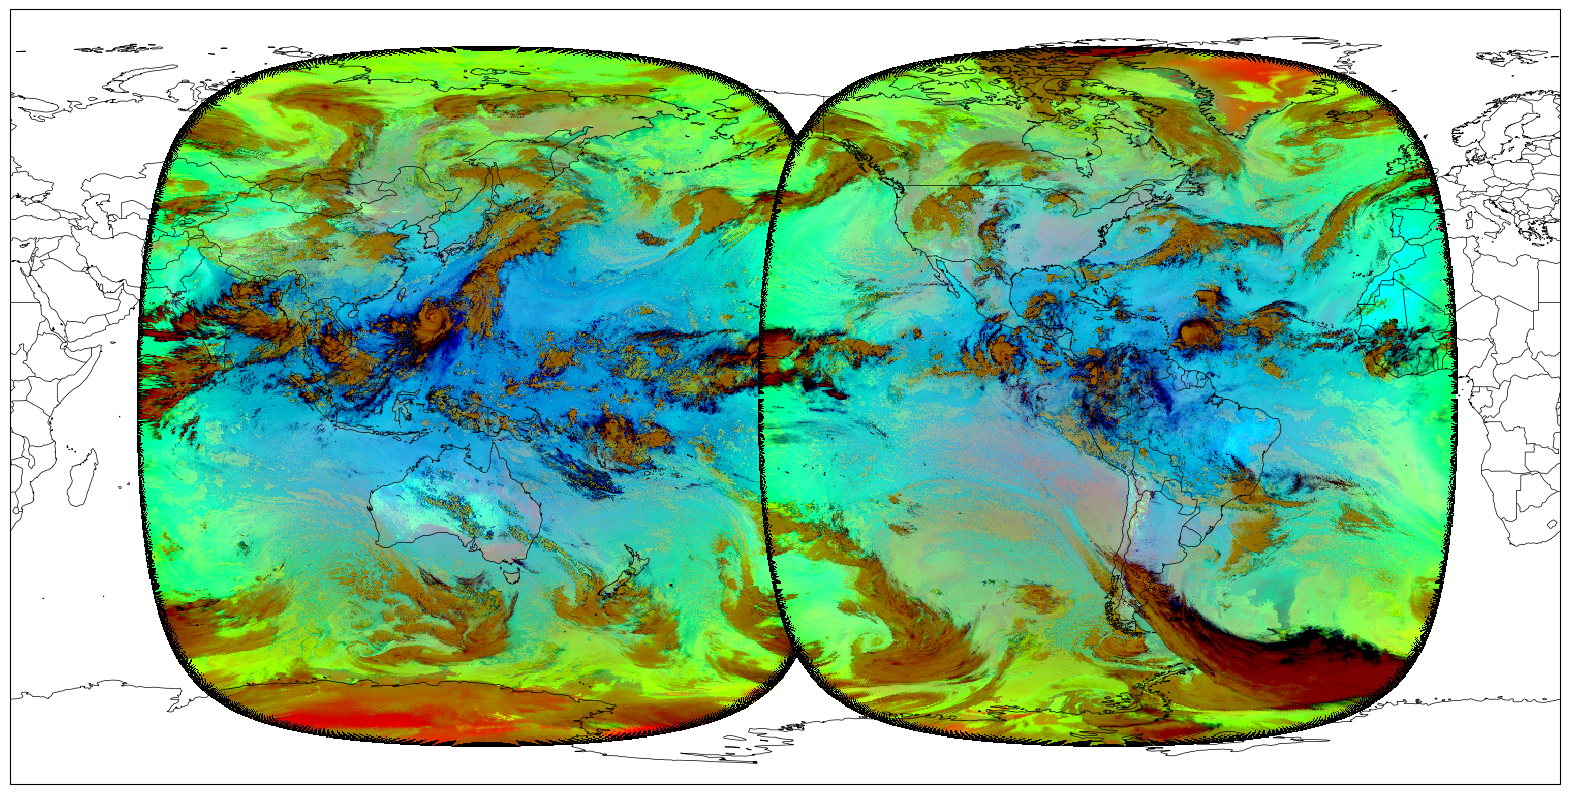

In [4]:
rgb_h, src_crs_h, src_extent_h = extract_himawari_visualization(da_h)

da_g = GOES(region="F", channels=("C11", "C14", "C15")).get("2023-10-01T12:00:00")
rgb_g, src_crs_g, src_extent_g = extract_goes_visualization(da_g)

dst_crs = ccrs.PlateCarree(central_longitude=-150.0)

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(projection=dst_crs)
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

ax.imshow(rgb_h, extent=src_extent_h, transform=src_crs_h, interpolation="none")
ax.imshow(rgb_g, extent=src_extent_g, transform=src_crs_g, interpolation="none");

## Himawari regional imagery

Himawari data is available for a Japan region (`region='J'`) and a dynamic target region (`region='T'`). Imagery over both are available every 2.5 minutes.

The two examples below were cherrypicked to show examples of contrail cirrus.

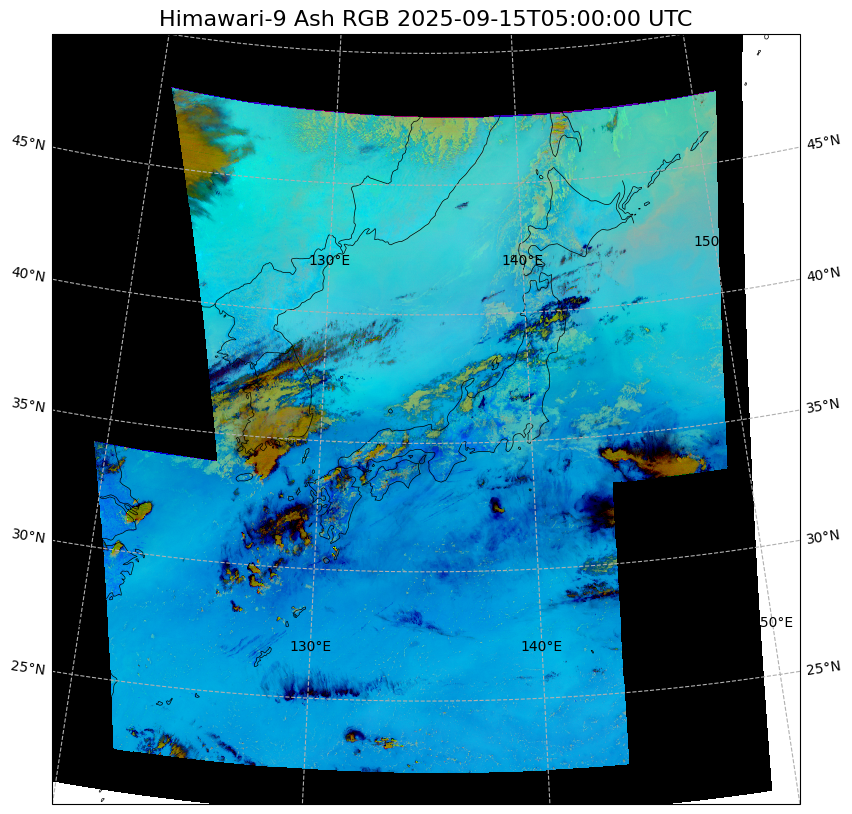

In [5]:
hima = Himawari(region="J")

t = "2025-09-15T05:00:00"
da_h = hima.get(t)

rgb, src_crs, src_extent = extract_himawari_visualization(da_h, color_scheme="ash")

dst_crs = ccrs.LambertConformal(
    central_longitude=135,
    central_latitude=35,
    standard_parallels=(30, 40),
)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=[120, 150, 20, 50])
ax.imshow(rgb, extent=src_extent, transform=src_crs, interpolation="none")

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
ax.set_title(f"Himawari-9 Ash RGB {t} UTC", fontsize=16)

gl = ax.gridlines(draw_labels=True, linestyle="--");

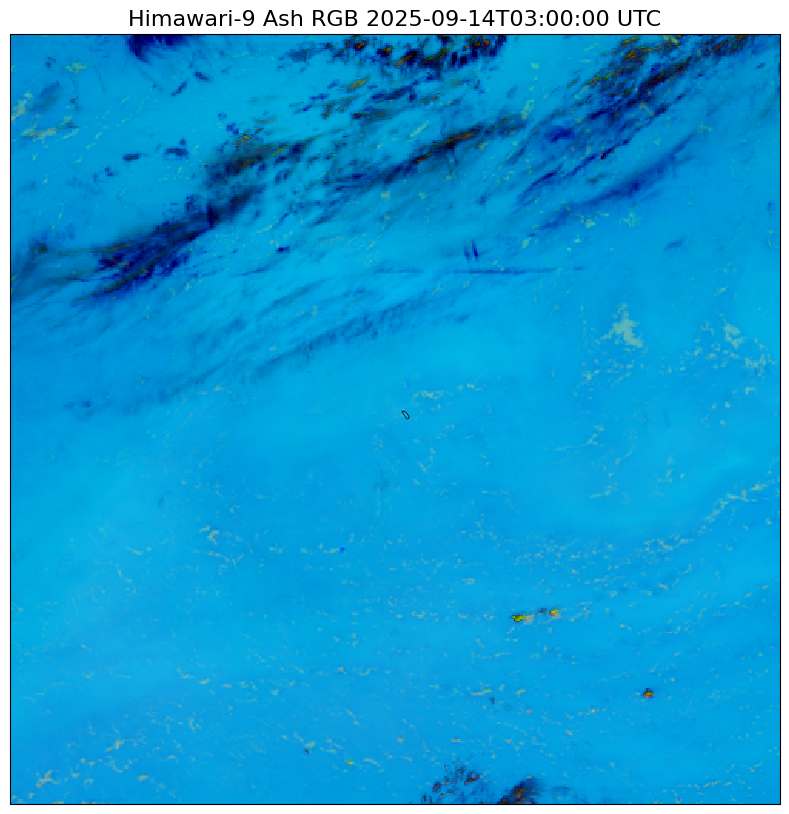

In [6]:
hima = Himawari(region="T")

t = "2025-09-14T03:00:00"
da_h = hima.get(t)

rgb, src_crs, src_extent = extract_himawari_visualization(da_h, color_scheme="ash")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=src_crs)
ax.imshow(rgb, extent=src_extent, transform=src_crs, interpolation="none")

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
ax.set_title(f"Himawari-9 Ash RGB {t} UTC", fontsize=16);